# Init

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%env DRIVE_DATA_DIR=./gdrive/MyDrive/master-thesis
%env COLAB_DATA_DIR=data

env: DRIVE_DATA_DIR=./gdrive/MyDrive/master-thesis
env: COLAB_DATA_DIR=data


In [3]:
import numpy as np
import keras
from keras import layers, initializers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import pickle

import seaborn as sn
import pandas as pd
from tensorflow import concat, argmax
from sklearn.metrics import roc_auc_score

import os
import tensorflow as tf
from itertools import cycle

# Configuration

## Static configuration

In [4]:
%env IMAGE_FORMAT=png

env: IMAGE_FORMAT=png


In [5]:
phase1optimizer="RMSprop"
phase2optimizer="RMSprop"

def phase_1_optimizer():
  return keras.optimizers.RMSprop()

def phase_2_optimizer():
  return keras.optimizers.RMSprop(1e-5)

In [6]:
batch_size = 32 # (TSAI VGG19)

In [15]:
epoch_counts = [5, 5]

In [8]:
seed=123

## Model selection

In [ ]:
model_name = "VGG19"

In [9]:
model_name = "MobileNetV2"

In [ ]:
model_name = "EfficientNetV2B0"

## Dataset selection

### Kather16

In [10]:
%env DATASET=Kather_texture_2016_image_tiles_5000

env: DATASET=Kather_texture_2016_image_tiles_5000


In [11]:
image_size=(150, 150)

### Kather19

In [ ]:
%env DATASET=NCT-CRC-HE-100K

In [ ]:
image_size=(224, 224)

Train / Validation / Test split = 70 / 15 / 15

*Tsai2021*

### Merged datasets

In [ ]:
%env DATASET=merged_datasets

In [ ]:
image_size=(100, 100)

# Loading images from drive

In [12]:
%%shell

mkdir $COLAB_DATA_DIR
cp $DRIVE_DATA_DIR/$DATASET.${IMAGE_FORMAT}.zip $COLAB_DATA_DIR
unzip $COLAB_DATA_DIR/$DATASET.${IMAGE_FORMAT}.zip -d . && rm $COLAB_DATA_DIR/$DATASET.${IMAGE_FORMAT}.zip

Streaming output truncated to the last 5000 lines.
  inflating: ./data/Kather_texture_2016_image_tiles_5000/06_MUCOSA/1145_CRC-Prim-HE-09_001.tif_Row_301_Col_1201.png  
  inflating: ./data/Kather_texture_2016_image_tiles_5000/06_MUCOSA/15C92_CRC-Prim-HE-06_033.tif_Row_451_Col_751.png  
  inflating: ./data/Kather_texture_2016_image_tiles_5000/06_MUCOSA/15569_CRC-Prim-HE-03_006.tif_Row_901_Col_451.png  
  inflating: ./data/Kather_texture_2016_image_tiles_5000/06_MUCOSA/2D99_CRC-Prim-HE-06_032.tif_Row_751_Col_1.png  
  inflating: ./data/Kather_texture_2016_image_tiles_5000/06_MUCOSA/15DD6_CRC-Prim-HE-03_007.tif_Row_451_Col_1.png  
  inflating: ./data/Kather_texture_2016_image_tiles_5000/06_MUCOSA/1633C_CRC-Prim-HE-03_006.tif_Row_1801_Col_301.png  
  inflating: ./data/Kather_texture_2016_image_tiles_5000/06_MUCOSA/2916_CRC-Prim-HE-03_006.tif_Row_1801_Col_601.png  
  inflating: ./data/Kather_texture_2016_image_tiles_5000/06_MUCOSA/13BD9_CRC-Prim-HE-07_001_copy.tif_Row_301_Col_301.png  
  in

# Calculate OvO ROC AUC for each class

In [ ]:
filename=f"{os.environ['DRIVE_DATA_DIR']}/test_results/{model_name}-{os.environ['DATASET']}-{os.environ['IMAGE_FORMAT']}-{image_size[0]}x{image_size[1]}-{batch_size}-{phase1optimizer}+{phase2optimizer}-70:15:15-test_results.pkl"

with open(filename, 'rb') as file:
  test_results = pickle.load(file)

In [ ]:
true_categories = test_results["true_categories"]
y_pred = test_results["y_pred"]
predicted_categories = test_results["predicted_categories"]
features = test_results["features"]
y_onehot_test = test_results["y_onehot_test"]
class_names = test_results["class_names"]

In [ ]:
roc_auc_matrix = np.zeros((len(class_names), len(class_names)))
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j:
            roc_auc_matrix[i, j] = roc_auc_score(y_onehot_test[:, i], y_pred[:, j])

print("One-vs-One ROC AUC Matrix:")
print(roc_auc_matrix)

One-vs-One ROC AUC Matrix:
[[0.         0.38622642 0.63924528 0.54550314 0.46632075 0.63827044
  0.2890566  0.32095912]
 [0.46485957 0.         0.6737949  0.51932555 0.56363084 0.34674588
  0.55338577 0.60162368]
 [0.71418015 0.77674686 0.         0.74822235 0.65294359 0.6630101
  0.4541588  0.53832006]
 [0.4408867  0.26842492 0.49291472 0.         0.32275606 0.51997633
  0.14707952 0.39760732]
 [0.49359756 0.65998476 0.52130335 0.41078506 0.         0.50015244
  0.55649771 0.66278582]
 [0.43861635 0.30877358 0.44100629 0.35988994 0.32995283 0.
  0.30256289 0.12512579]
 [0.09309658 0.21378318 0.03117671 0.05249985 0.25294129 0.09747157
  0.         0.39325621]
 [0.26701796 0.40423875 0.13950752 0.26948698 0.45863989 0.13362498
  0.82105455 0.        ]]


<Axes: >

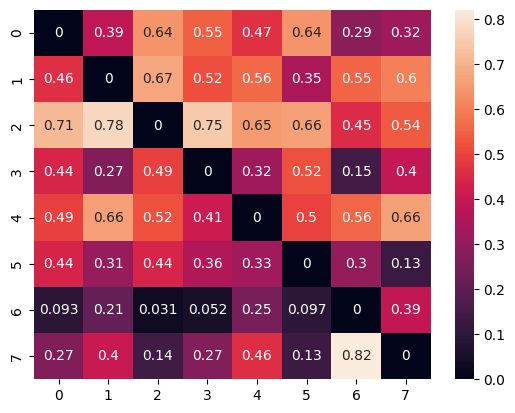

In [ ]:
import seaborn as sns
sns.heatmap(roc_auc_matrix, annot=True)

In [ ]:
class_names

['01_TUMOR',
 '02_STROMA',
 '03_COMPLEX',
 '04_LYMPHO',
 '05_DEBRIS',
 '06_MUCOSA',
 '07_ADIPOSE',
 '08_EMPTY']

In [ ]:
def reduce_matrix(original_matrix):
  matrix = original_matrix.copy()
  np.fill_diagonal(matrix, 0)
  for q in range(4):
      i,j = np.unravel_index(np.argmax(matrix), matrix.shape)
      value = matrix[i,j]

      if(sum(matrix[i,:])>0):
        matrix[i, :] = 0
        matrix[:, j] = 0
        matrix[j, :] = 0
        matrix[:, i] = 0
        matrix[i,j] = -value
        print(-value)
  return matrix

# Output the final matrix
reduced_matrix=reduce_matrix(roc_auc_matrix)
reduced_matrix

-0.8210545502750712
-0.7767468593480581
-0.6382704402515723
-0.41078506097560974


array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.63827044,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        , -0.77674686,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , -0.41078506,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.82105455,  0.        ]])

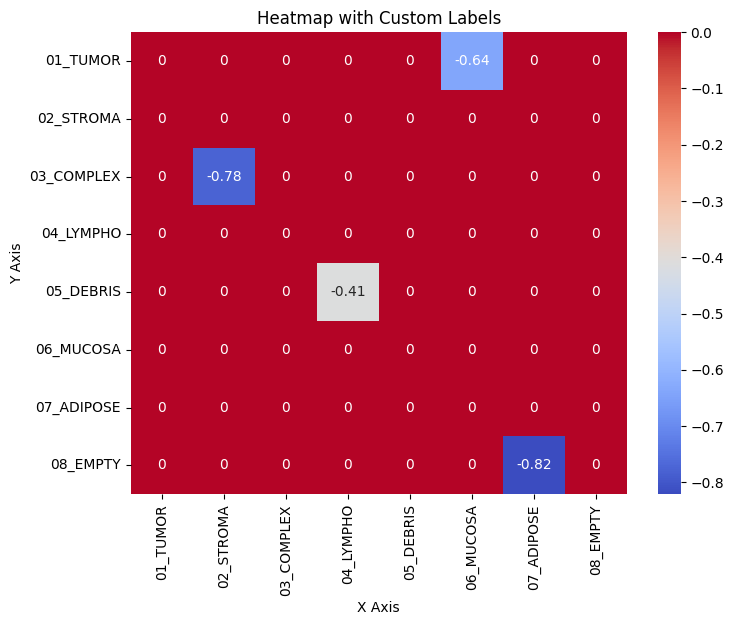

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# x and y axis values
x_labels = class_names
y_labels = x_labels.copy()

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(reduced_matrix, annot=True, cmap='coolwarm', xticklabels=x_labels, yticklabels=y_labels)
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.title('Heatmap with Custom Labels')
plt.show()


In [ ]:
def get_pairs(original_matrix, class_names):
  matrix = original_matrix.copy()
  np.fill_diagonal(matrix, 0)
  for q in range(4):
      i,j = np.unravel_index(np.argmin(matrix), matrix.shape)
      matrix[i,j] = 0
      print(i, class_names[i], " VS ", j, class_names[j])


# Output the final matrix
get_pairs(reduced_matrix,class_names)

7 08_EMPTY  VS  6 07_ADIPOSE
2 03_COMPLEX  VS  1 02_STROMA
0 01_TUMOR  VS  5 06_MUCOSA
4 05_DEBRIS  VS  3 04_LYMPHO


In [ ]:
from itertools import pairwise, combinations

In [ ]:

original = [(7, 6), (2, 1), (0, 5), (4, 3)]
reversed = [(b, a) for (a, b) in original]

all = original #+ reversed


def getScore(matrix, pair):
  return min([matrix[pair[0][0], pair[1][0]], matrix[pair[0][0], pair[1][1]], matrix[pair[0][1], pair[1][0]], matrix[pair[0][1], pair[1][1]]])


all_combinations = list(combinations(all, 2))


results = [0] * len(all_combinations)


for index, subset in enumerate(all_combinations):
  results[index]=getScore(roc_auc_matrix, subset)


print(all_combinations[np.argmin(results)], np.argmin(results))
results[0]=1
print(all_combinations[np.argmin(results)])


((7, 6), (2, 1)) 0
((7, 6), (4, 3))


In [ ]:
[(7, 6), (2, 1), (0, 5), (4, 3)] -> [(?,?), (?,?)], [(?,?), (?,?)]

TO je prva razina parova, sad gledamo kako parove grupirat

- 8 - 7
- 3 - 2

ILI

- 8 - 7
- 2 - 3

tražimo max,
- 7 - 2
- 7 - 3
- 8 - 2
- 8 - 3

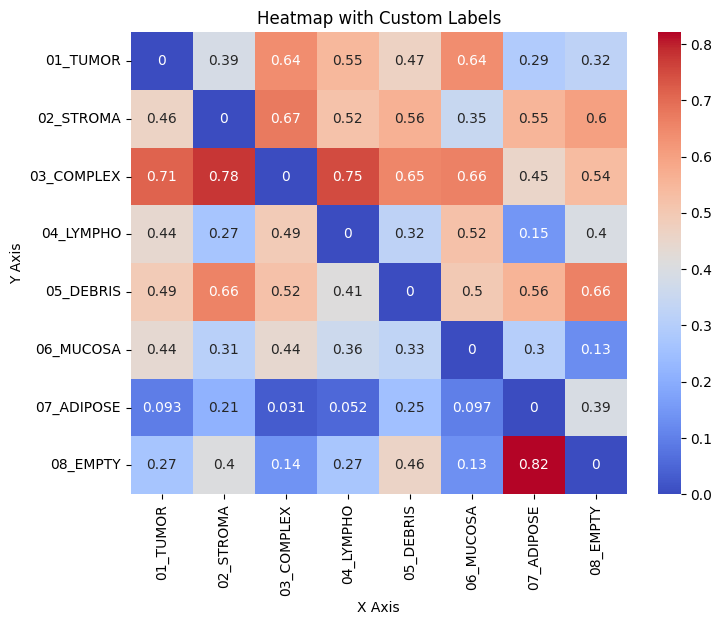

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# x and y axis values
x_labels = class_names
y_labels = x_labels.copy()

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(roc_auc_matrix, annot=True, cmap='coolwarm', xticklabels=x_labels, yticklabels=y_labels)
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.title('Heatmap with Custom Labels')
plt.show()


# Spliting dataset

In [ ]:
! mkdir $COLAB_DATA_DIR/${DATASET}_{1,2}

In [ ]:
%%shell

cp -r $COLAB_DATA_DIR/${DATASET}/08_EMPTY $COLAB_DATA_DIR/${DATASET}_1;
cp -r $COLAB_DATA_DIR/${DATASET}/03_COMPLEX $COLAB_DATA_DIR/${DATASET}_1;
cp -r $COLAB_DATA_DIR/${DATASET}/01_TUMOR $COLAB_DATA_DIR/${DATASET}_1;
cp -r $COLAB_DATA_DIR/${DATASET}/05_DEBRIS $COLAB_DATA_DIR/${DATASET}_1;


cp -r $COLAB_DATA_DIR/${DATASET}/07_ADIPOSE $COLAB_DATA_DIR/${DATASET}_2;
cp -r $COLAB_DATA_DIR/${DATASET}/02_STROMA $COLAB_DATA_DIR/${DATASET}_2;
cp -r $COLAB_DATA_DIR/${DATASET}/06_MUCOSA $COLAB_DATA_DIR/${DATASET}_2;
cp -r $COLAB_DATA_DIR/${DATASET}/04_LYMPHO $COLAB_DATA_DIR/${DATASET}_2;

In [ ]:
# DEBRIS
# NORM
# BACK
# STROMA
# LYMPHO
# MUS
# ADIPOSE
# TUMOR
# MUCOSA


# 7 08_EMPTY  VS  6 07_ADIPOSE
# 2 03_COMPLEX  VS  1 02_STROMA
# 0 01_TUMOR  VS  5 06_MUCOSA
# 4 05_DEBRIS  VS  3 04_LYMPHO

# Load datasets

## First half

In [ ]:
dataset_1=os.environ['COLAB_DATA_DIR']+"/"+os.environ['DATASET']+"_1/"

In [ ]:
train_ds_1, validation_ds_1 = keras.utils.image_dataset_from_directory(
    dataset_1,
    labels="inferred",
    label_mode="int",
    # class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    seed=seed,
    validation_split=0.95, # 0.3
    subset="both",
    crop_to_aspect_ratio=False
)

Found 2500 files belonging to 4 classes.
Using 125 files for training.
Using 2375 files for validation.


In [ ]:
val_batches_1 = validation_ds_1.cardinality().numpy()         # 70 %
test_ds_1 = validation_ds_1.take(( 1 * val_batches_1) // 2) # 7*val_batches) // 8)        # 15 %
validation_ds_1 = validation_ds_1.skip(( 1 * val_batches_1) // 2) # 7*val_batches) // 8)  # 15 %

# https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cardinality
# https://stackoverflow.com/a/74609848/12108610

In [ ]:
# number of files / batch size
print(f"Number of training samples: {train_ds_1.cardinality().numpy() * batch_size}")
print(f"Number of validation samples: {validation_ds_1.cardinality().numpy() * batch_size}")
print(f"Number of test samples: {test_ds_1.cardinality().numpy() * batch_size}")

Number of training samples: 128
Number of validation samples: 1216
Number of test samples: 1184


In [ ]:
class_names_1 = train_ds_1.class_names
class_names_1

['01_TUMOR', '03_COMPLEX', '05_DEBRIS', '08_EMPTY']

In [ ]:
number_of_classes_1 = len(class_names_1)

## Second half

In [ ]:
dataset_2=os.environ['COLAB_DATA_DIR']+"/"+os.environ['DATASET']+"_2/"

In [ ]:
train_ds_2, validation_ds_2 = keras.utils.image_dataset_from_directory(
    dataset_2,
    labels="inferred",
    label_mode="int",
    # class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    seed=seed,
    validation_split=0.95, # 0.3
    subset="both",
    crop_to_aspect_ratio=False
)

Found 2500 files belonging to 4 classes.
Using 125 files for training.
Using 2375 files for validation.


In [ ]:
val_batches_2 = validation_ds_2.cardinality().numpy()         # 70 %
test_ds_2 = validation_ds_2.take(( 1 * val_batches_2) // 2) # 7*val_batches) // 8)        # 15 %
validation_ds_2 = validation_ds_2.skip(( 1 * val_batches_2) // 2) # 7*val_batches) // 8)  # 15 %

# https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cardinality
# https://stackoverflow.com/a/74609848/12108610

In [ ]:
# number of files / batch size
print(f"Number of training samples: {train_ds_2.cardinality().numpy() * batch_size}")
print(f"Number of validation samples: {validation_ds_2.cardinality().numpy() * batch_size}")
print(f"Number of test samples: {test_ds_2.cardinality().numpy() * batch_size}")

Number of training samples: 128
Number of validation samples: 1216
Number of test samples: 1184


In [ ]:
class_names_2 = train_ds_2.class_names
class_names_2

['02_STROMA', '04_LYMPHO', '06_MUCOSA', '07_ADIPOSE']

In [ ]:
number_of_classes_2 = len(class_names_2)

## All

In [16]:
dataset=os.environ['COLAB_DATA_DIR']+"/"+os.environ['DATASET']+"/"

In [67]:
train_ds, validation_ds = keras.utils.image_dataset_from_directory(
    dataset,
    labels="inferred",
    label_mode="int",
    # class_names=None,
    color_mode="rgb",
    batch_size= None, # batch_size,
    image_size=image_size,
    shuffle=True,
    seed=seed,
    validation_split=0.3, # 0.3
    subset="both",
    crop_to_aspect_ratio=False
)

Found 5000 files belonging to 8 classes.
Using 3500 files for training.
Using 1500 files for validation.


In [68]:
val_batches = validation_ds.cardinality().numpy()         # 70 %
test_ds = validation_ds.take(( 1 * val_batches) // 2) # 7*val_batches) // 8)        # 15 %
validation_ds = validation_ds.skip(( 1 * val_batches) // 2) # 7*val_batches) // 8)  # 15 %

# https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cardinality
# https://stackoverflow.com/a/74609848/12108610

In [69]:
# number of files / batch size
print(f"Number of training samples: {train_ds.cardinality().numpy() * batch_size}")
print(f"Number of validation samples: {validation_ds.cardinality().numpy() * batch_size}")
print(f"Number of test samples: {test_ds.cardinality().numpy() * batch_size}")

Number of training samples: 112000
Number of validation samples: 24000
Number of test samples: 24000


In [70]:
class_names = train_ds.class_names
class_names

['01_TUMOR',
 '02_STROMA',
 '03_COMPLEX',
 '04_LYMPHO',
 '05_DEBRIS',
 '06_MUCOSA',
 '07_ADIPOSE',
 '08_EMPTY']

In [71]:
number_of_classes = len(class_names)

### Pokusaj da se rastavi Dataset na drugi nacin

In [22]:
class_indexes_to_keep_1 = tf.constant([0, 2, 4, 7], dtype=tf.int32)
class_indexes_to_keep_2 = tf.constant([1, 3, 5, 6], dtype=tf.int32)

table_1 = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant([0, 2, 4, 7], dtype=tf.int32),
        values=tf.constant([0, 1, 2, 3],  dtype=tf.int32),
    ),
    default_value= tf.constant(0,  dtype=tf.int32)
)

table_2 = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant([1, 3, 5, 6], dtype=tf.int32),
        values=tf.constant([0, 1, 2, 3],  dtype=tf.int32),
    ),
    default_value= tf.constant(0,  dtype=tf.int32)
)

table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant([0, 2, 4, 7, 1, 3, 5, 6], dtype=tf.int32),
        values=tf.constant([0, 1, 2, 3, 4, 5, 6, 7],  dtype=tf.int32),
    ),
    default_value= tf.constant(0,  dtype=tf.int32)
)

In [72]:
class_indexes_to_keep_1 = tf.constant([0, 2, 4, 7], dtype=tf.int32)
class_indexes_to_keep_2 = tf.constant([1, 3, 5, 6], dtype=tf.int32)

table_1 = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant([0, 2, 4, 7, 1, 3, 5, 6], dtype=tf.int32),
        values=tf.constant([0, 1, 2, 3, 4, 4, 4, 4],  dtype=tf.int32),
    ),
    default_value= tf.constant(0,  dtype=tf.int32)
)

table_2 = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant([0, 2, 4, 7, 1, 3, 5, 6], dtype=tf.int32),
        values=tf.constant([4, 4, 4, 4, 0, 1, 2, 3],  dtype=tf.int32),
    ),
    default_value= tf.constant(0,  dtype=tf.int32)
)

table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant([0, 2, 4, 7, 1, 3, 5, 6], dtype=tf.int32),
        values=tf.constant([0, 1, 2, 3, 4, 5, 6, 7],  dtype=tf.int32),
    ),
    default_value= tf.constant(0,  dtype=tf.int32)
)

In [73]:
def relabel_map_1(x,y):
    return x,table_1.lookup(y)

def relabel_map_2(x,y):
    return x,table_2.lookup(y)

def relabel_map(x,y):
    return x,table.lookup(y)

In [74]:
# true_categories = concat([y for x, y in train_ds_1], axis=0).numpy()
# true_categories[:10]

In [75]:
train_ds_1 = train_ds.filter(lambda x, y: tf.reduce_any(y == class_indexes_to_keep_1)).map(relabel_map_1).batch(batch_size)
validation_ds_1 = validation_ds.filter(lambda x, y: tf.reduce_any(y == class_indexes_to_keep_1)).map(relabel_map_1).batch(batch_size)
test_ds_1 = test_ds.filter(lambda x, y: tf.reduce_any(y == class_indexes_to_keep_1)).map(relabel_map_1).batch(batch_size)


train_ds_2 = train_ds.filter(lambda x, y: tf.reduce_any(y == class_indexes_to_keep_2)).map(relabel_map_2).batch(batch_size)
validation_ds_2 = validation_ds.filter(lambda x, y: tf.reduce_any(y == class_indexes_to_keep_2)).map(relabel_map_2).batch(batch_size)
test_ds_2 = test_ds.filter(lambda x, y: tf.reduce_any(y == class_indexes_to_keep_2)).map(relabel_map_2).batch(batch_size)

In [76]:
train_ds = train_ds.map(relabel_map).batch(batch_size)
validation_ds = validation_ds.map(relabel_map).batch(batch_size)
test_ds = test_ds.map(relabel_map).batch(batch_size)


# train_ds = train_ds.batch(batch_size)
# validation_ds = validation_ds.batch(batch_size)
# test_ds = test_ds.batch(batch_size)

# Training Kather16

## MobileNetV2 part 1

In [27]:
model_name_1 = "MobileNetV2"

In [28]:
base_model_1 = keras.applications.MobileNetV2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(image_size[0], image_size[1], 3),
    include_top=False,
    alpha=1.0
)  # Do not include the ImageNet classifier at the top.

9406464/9406464 [==============================] - 1s 0us/step


In [29]:
# Freeze the base_model
base_model_1.trainable = False

# Create new model on top
inputs_1 = keras.Input(shape=(image_size[0], image_size[1], 3))


# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer_1 = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x_1 = scale_layer_1(inputs_1)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x_1 = base_model_1(x_1, training=False)
x_1 = keras.layers.GlobalAveragePooling2D()(x_1)
x_1 = keras.layers.Dropout(0.2)(x_1)  # Regularize with dropout
outputs_1 = keras.layers.Dense(5, activation='softmax')(x_1)
model_1 = keras.Model(inputs_1, outputs_1)

model_1.summary(show_trainable=True)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         Y          
                                                                            
 rescaling (Rescaling)       (None, 150, 150, 3)       0         Y          
                                                                            
 mobilenetv2_1.00_224 (Func  (None, 5, 5, 1280)        2257984   N          
 tional)                                                                    
                                                                            
 global_average_pooling2d (  (None, 1280)              0         Y          
 GlobalAveragePooling2D)                                                    
                                                                            
 dropout (Dropout)           (None, 1280)              0     

In [30]:
model_1.compile(
    optimizer=phase_1_optimizer(),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy'],
)

print("Fitting the top layer of the model")
model_1.fit(train_ds_1, epochs=epoch_counts[0], validation_data=validation_ds_1)

Fitting the top layer of the model
Epoch 1/5
55/55 [==============================] - 15s 145ms/step - loss: 0.6648 - accuracy: 0.7490 - val_loss: 0.3430 - val_accuracy: 0.8688
Epoch 2/5
55/55 [==============================] - 10s 172ms/step - loss: 0.2933 - accuracy: 0.8951 - val_loss: 0.3069 - val_accuracy: 0.8714
Epoch 3/5
55/55 [==============================] - 8s 120ms/step - loss: 0.2160 - accuracy: 0.9163 - val_loss: 0.2624 - val_accuracy: 0.9134
Epoch 4/5
55/55 [==============================] - 5s 77ms/step - loss: 0.1805 - accuracy: 0.9398 - val_loss: 0.2142 - val_accuracy: 0.9160
Epoch 5/5
55/55 [==============================] - 5s 73ms/step - loss: 0.1539 - accuracy: 0.9496 - val_loss: 0.2119 - val_accuracy: 0.9186


In [31]:
accuracy_phase_1_1 = model_1.history.history["accuracy"]
val_accuracy_phase_1_1 = model_1.history.history["val_accuracy"]

In [32]:
loss_phase_1_1 = model_1.history.history["loss"]
val_loss_phase_1_1 = model_1.history.history["val_loss"]

In [33]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model_1.trainable = True
model_1.summary(show_trainable=True)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         Y          
                                                                            
 rescaling (Rescaling)       (None, 150, 150, 3)       0         Y          
                                                                            
 mobilenetv2_1.00_224 (Func  (None, 5, 5, 1280)        2257984   Y          
 tional)                                                                    
                                                                            
 global_average_pooling2d (  (None, 1280)              0         Y          
 GlobalAveragePooling2D)                                                    
                                                                            
 dropout (Dropout)           (None, 1280)              0     

In [34]:
model_1.compile(
    optimizer=phase_2_optimizer(),  # Low learning rate
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy'],
)

print("Fitting the end-to-end model")
model_1.fit(train_ds_1, epochs=epoch_counts[1], validation_data=validation_ds_1)

Fitting the end-to-end model
Epoch 1/5
55/55 [==============================] - 31s 172ms/step - loss: 0.1584 - accuracy: 0.9450 - val_loss: 0.2446 - val_accuracy: 0.9186
Epoch 2/5
55/55 [==============================] - 7s 104ms/step - loss: 0.1027 - accuracy: 0.9662 - val_loss: 0.1462 - val_accuracy: 0.9423
Epoch 3/5
55/55 [==============================] - 9s 152ms/step - loss: 0.0625 - accuracy: 0.9822 - val_loss: 0.1169 - val_accuracy: 0.9633
Epoch 4/5
55/55 [==============================] - 7s 119ms/step - loss: 0.0441 - accuracy: 0.9851 - val_loss: 0.1052 - val_accuracy: 0.9633
Epoch 5/5
55/55 [==============================] - 7s 118ms/step - loss: 0.0318 - accuracy: 0.9897 - val_loss: 0.1005 - val_accuracy: 0.9685


### Accuracy

In [35]:
accuracy_phase_2_1 = model_1.history.history["accuracy"]
val_accuracy_phase_2_1 = model_1.history.history["val_accuracy"]

In [36]:
loss_phase_2_1 = model_1.history.history["loss"]
val_loss_phase_2_1 = model_1.history.history["val_loss"]

In [37]:
print("Test dataset evaluation")
model_1.evaluate(test_ds_1)

Test dataset evaluation
12/12 [==============================] - 2s 167ms/step - loss: 0.1125 - accuracy: 0.9572


[0.11250944435596466, 0.9572192430496216]

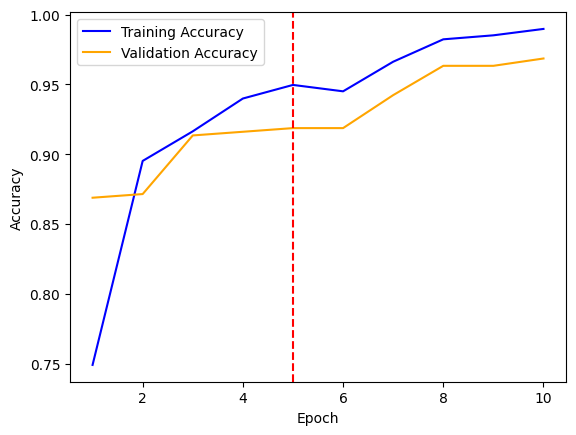

In [38]:
# Visualize loss history
plt.plot(range(1, sum(epoch_counts) + 1), accuracy_phase_1_1+accuracy_phase_2_1, color='blue')
plt.plot(range(1, sum(epoch_counts) + 1), val_accuracy_phase_1_1+val_accuracy_phase_2_1, color='orange')
plt.axvline(x=epoch_counts[0], color='r', linestyle='--')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

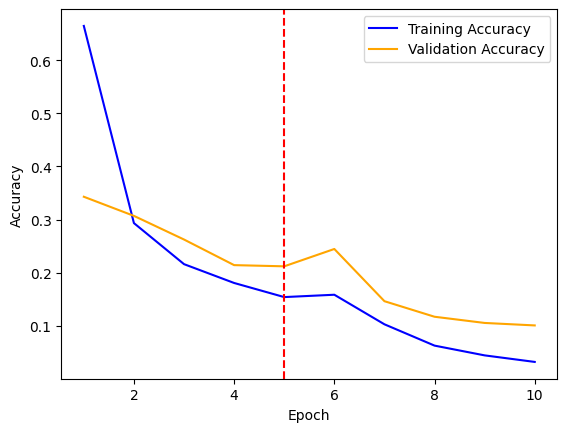

In [39]:
# Visualize loss history
plt.plot(range(1, sum(epoch_counts) + 1), loss_phase_1_1+loss_phase_2_1, color='blue')
plt.plot(range(1, sum(epoch_counts) + 1), val_loss_phase_1_1+val_loss_phase_2_1, color='orange')
plt.axvline(x=epoch_counts[0], color='r', linestyle='--')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

## MobileNetV2 part 2

In [40]:
model_name_2 = "MobileNetV2"

In [41]:
base_model_2 = keras.applications.MobileNetV2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(image_size[0], image_size[1], 3),
    include_top=False,
    alpha=1.0
)  # Do not include the ImageNet classifier at the top.

In [42]:
# Freeze the base_model
base_model_2.trainable = False

# Create new model on top
inputs_2 = keras.Input(shape=(image_size[0], image_size[1], 3))


# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer_2 = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x_2 = scale_layer_2(inputs_2)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x_2 = base_model_2(x_2, training=False)
x_2 = keras.layers.GlobalAveragePooling2D()(x_2)
x_2 = keras.layers.Dropout(0.2)(x_2)  # Regularize with dropout
outputs_2 = keras.layers.Dense(5, activation='softmax')(x_2)
model_2 = keras.Model(inputs_2, outputs_2)

model_2.summary(show_trainable=True)

Model: "model_1"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         Y          
                                                                            
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         Y          
                                                                            
 mobilenetv2_1.00_224 (Func  (None, 5, 5, 1280)        2257984   N          
 tional)                                                                    
                                                                            
 global_average_pooling2d_1  (None, 1280)              0         Y          
  (GlobalAveragePooling2D)                                                  
                                                                            
 dropout_1 (Dropout)         (None, 1280)              0   

In [43]:
model_2.compile(
    optimizer=phase_1_optimizer(),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy'],
)

print("Fitting the top layer of the model")
model_2.fit(train_ds_2, epochs=epoch_counts[0], validation_data=validation_ds_2)


Fitting the top layer of the model
Epoch 1/5
55/55 [==============================] - 11s 142ms/step - loss: 0.4448 - accuracy: 0.8484 - val_loss: 0.1760 - val_accuracy: 0.9350
Epoch 2/5
55/55 [==============================] - 6s 88ms/step - loss: 0.1321 - accuracy: 0.9544 - val_loss: 0.1442 - val_accuracy: 0.9458
Epoch 3/5
55/55 [==============================] - 7s 116ms/step - loss: 0.0896 - accuracy: 0.9698 - val_loss: 0.1412 - val_accuracy: 0.9566
Epoch 4/5
55/55 [==============================] - 5s 76ms/step - loss: 0.0644 - accuracy: 0.9801 - val_loss: 0.0988 - val_accuracy: 0.9621
Epoch 5/5
55/55 [==============================] - 6s 99ms/step - loss: 0.0533 - accuracy: 0.9829 - val_loss: 0.1230 - val_accuracy: 0.9593


In [44]:
accuracy_phase_1_2 = model_2.history.history["accuracy"]
val_accuracy_phase_1_2 = model_2.history.history["val_accuracy"]

In [45]:
loss_phase_1_2 = model_2.history.history["loss"]
val_loss_phase_1_2 = model_2.history.history["val_loss"]

In [46]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model_2.trainable = True
model_2.summary(show_trainable=True)

Model: "model_1"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         Y          
                                                                            
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         Y          
                                                                            
 mobilenetv2_1.00_224 (Func  (None, 5, 5, 1280)        2257984   Y          
 tional)                                                                    
                                                                            
 global_average_pooling2d_1  (None, 1280)              0         Y          
  (GlobalAveragePooling2D)                                                  
                                                                            
 dropout_1 (Dropout)         (None, 1280)              0   

In [47]:
model_2.compile(
    optimizer=phase_2_optimizer(),  # Low learning rate
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy'],
)

print("Fitting the end-to-end model")
model_2.fit(train_ds_2, epochs=epoch_counts[1], validation_data=validation_ds_2)

Fitting the end-to-end model
Epoch 1/5
55/55 [==============================] - 24s 150ms/step - loss: 0.0440 - accuracy: 0.9823 - val_loss: 0.0883 - val_accuracy: 0.9702
Epoch 2/5
55/55 [==============================] - 11s 165ms/step - loss: 0.0320 - accuracy: 0.9880 - val_loss: 0.0704 - val_accuracy: 0.9756
Epoch 3/5
55/55 [==============================] - 8s 119ms/step - loss: 0.0210 - accuracy: 0.9937 - val_loss: 0.0804 - val_accuracy: 0.9729
Epoch 4/5
55/55 [==============================] - 8s 123ms/step - loss: 0.0125 - accuracy: 0.9954 - val_loss: 0.1514 - val_accuracy: 0.9593
Epoch 5/5
55/55 [==============================] - 7s 106ms/step - loss: 0.0118 - accuracy: 0.9949 - val_loss: 0.0935 - val_accuracy: 0.9702


55/55 [==============================] - 4s 60ms/step


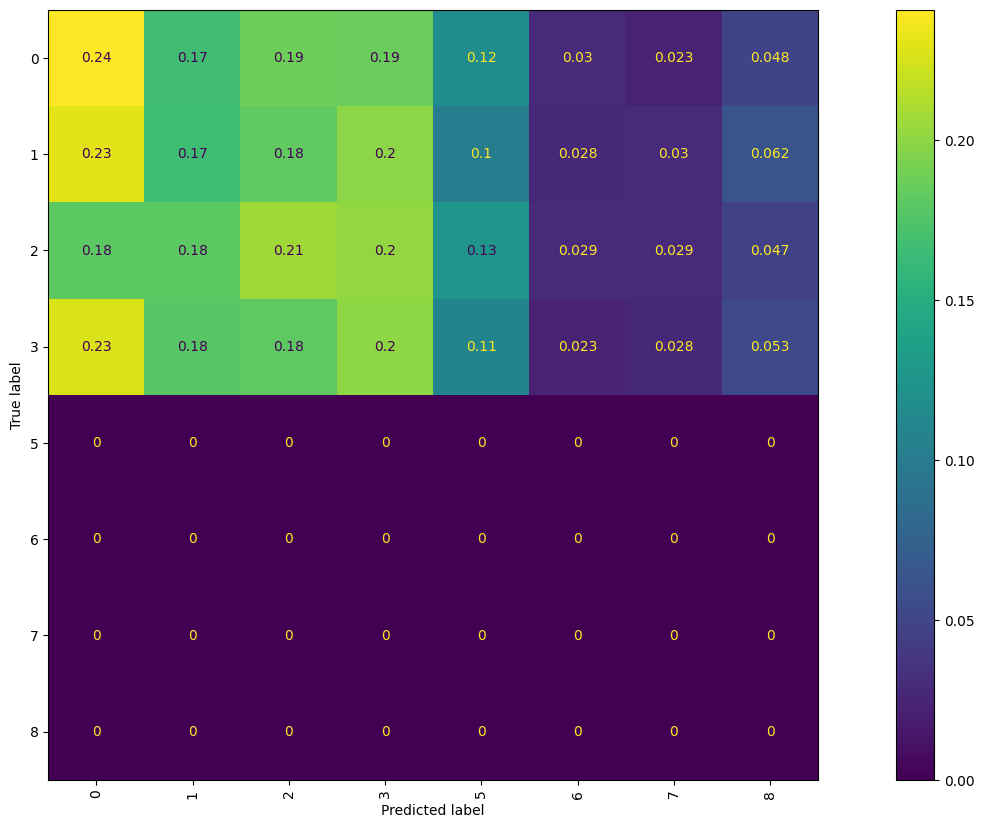

In [77]:
true_categories = concat([y for x, y in test_ds_1], axis=0).numpy()
true_categories.shape
y_pred = combined_model.predict(test_ds_1)
predicted_categories = argmax(y_pred, axis=1).numpy()
predicted_categories.shape
fig, ax = plt.subplots(figsize=(20, 10))
ConfusionMatrixDisplay.from_predictions(true_categories, predicted_categories, xticks_rotation="vertical", normalize='true', ax=ax)
plt.show()

12/12 [==============================] - 1s 85ms/step


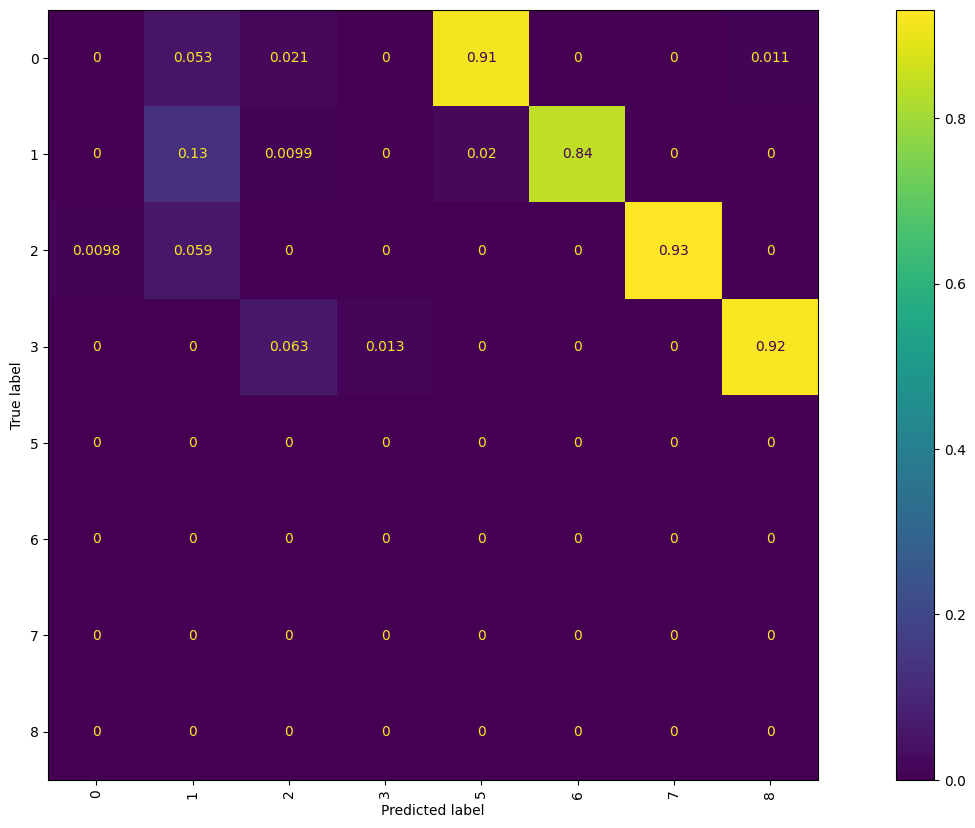

In [65]:
true_categories = concat([y for x, y in test_ds_2], axis=0).numpy()
true_categories.shape
y_pred = combined_model.predict(test_ds_2)
predicted_categories = argmax(y_pred, axis=1).numpy()
predicted_categories.shape
fig, ax = plt.subplots(figsize=(20, 10))
ConfusionMatrixDisplay.from_predictions(true_categories, predicted_categories, xticks_rotation="vertical", normalize='true', ax=ax)
plt.show()

### Accuracy

In [48]:
accuracy_phase_2_2 = model_2.history.history["accuracy"]
val_accuracy_phase_2_2 = model_2.history.history["val_accuracy"]

In [49]:
loss_phase_2_2 = model_2.history.history["loss"]
val_loss_phase_2_2 = model_2.history.history["val_loss"]

In [50]:
print("Test dataset evaluation")
model_2.evaluate(test_ds_2)

Test dataset evaluation
12/12 [==============================] - 2s 187ms/step - loss: 0.1011 - accuracy: 0.9761


[0.10111736506223679, 0.9760638475418091]

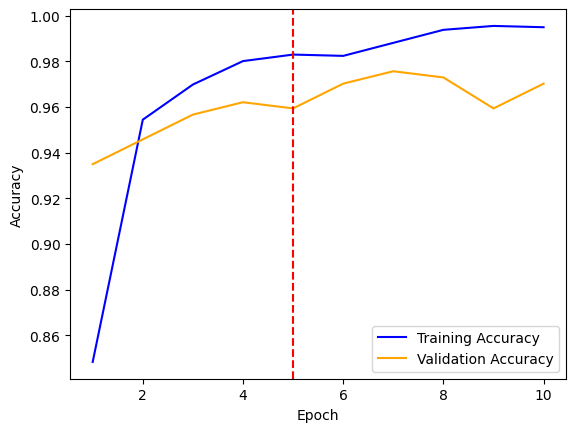

In [51]:
# Visualize loss history
plt.plot(range(1, sum(epoch_counts) + 1), accuracy_phase_1_2+accuracy_phase_2_2, color='blue')
plt.plot(range(1, sum(epoch_counts) + 1), val_accuracy_phase_1_2+val_accuracy_phase_2_2, color='orange')
plt.axvline(x=epoch_counts[0], color='r', linestyle='--')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

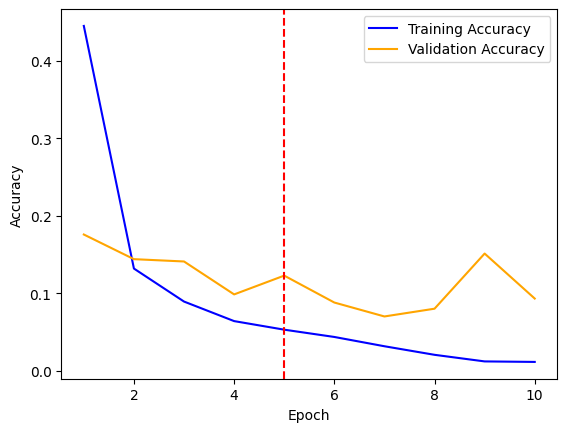

In [52]:
# Visualize loss history
plt.plot(range(1, sum(epoch_counts) + 1), loss_phase_1_2+loss_phase_2_2, color='blue')
plt.plot(range(1, sum(epoch_counts) + 1), val_loss_phase_1_2+val_loss_phase_2_2, color='orange')
plt.axvline(x=epoch_counts[0], color='r', linestyle='--')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

## Concatenate layer outputs

In [ ]:
model_1.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 rescaling_12 (Rescaling)    (None, 150, 150, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
 2 (GlobalAveragePooling2D)                                      
                                                                 
 dropout_12 (Dropout)        (None, 1280)              0         
                                                                 
 dense_15 (Dense)            (None, 4)                 512

In [ ]:
model_2.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 rescaling_13 (Rescaling)    (None, 150, 150, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
 3 (GlobalAveragePooling2D)                                      
                                                                 
 dropout_13 (Dropout)        (None, 1280)              0         
                                                                 
 dense_16 (Dense)            (None, 4)                 512

In [56]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate


model_1.trainable = False
model_2.trainable = False

# model_1_no_last_layer = Model(inputs=model_1.input, outputs=model_1.layers[-2].output)
# model_2_no_last_layer = Model(inputs=model_2.input, outputs=model_2.layers[-2].output)

inputs = keras.Input(shape=(image_size[0], image_size[1], 3))

model_1_output = model_1(inputs, training=False)
model_2_output = model_2(inputs, training=False)
concatenated_output = Concatenate()([model_1_output, model_2_output])

# mid = keras.layers.Dense(160, activation='softmax')(concatenated_output)

# dense_layer = keras.layers.Dense(8, activation='softmax')(concatenated_output)


combined_model = Model(inputs=inputs, outputs=concatenated_output)

combined_model.summary(show_trainable=True)

Model: "model_3"
_____________________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  Trainable  
 input_6 (InputLayer)        [(None, 150, 150, 3)]        0         []                            Y          
                                                                                                             
 model (Functional)          (None, 5)                    2264389   ['input_6[0][0]']             N          
                                                                                                             
 model_1 (Functional)        (None, 5)                    2264389   ['input_6[0][0]']             N          
                                                                                                             
 concatenate_1 (Concatenate  (None, 10)                   0         ['model[2][0]',               Y    

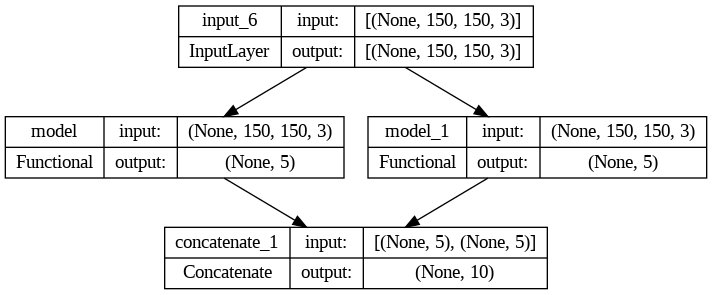

In [57]:
tf.keras.utils.plot_model(
    combined_model,
    show_shapes=True,
)

In [58]:
combined_model.compile(
    optimizer=phase_1_optimizer(),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy'],
)

In [ ]:
combined_model.fit(train_ds, epochs=2, validation_data=validation_ds)

Epoch 1/5
110/110 [==============================] - 16s 73ms/step - loss: 0.7125 - accuracy: 0.7783 - val_loss: 0.4248 - val_accuracy: 0.8520
Epoch 2/5
110/110 [==============================] - 9s 63ms/step - loss: 0.3046 - accuracy: 0.8903 - val_loss: 0.3327 - val_accuracy: 0.8960
Epoch 3/5
110/110 [==============================] - 8s 66ms/step - loss: 0.2087 - accuracy: 0.9254 - val_loss: 0.4736 - val_accuracy: 0.8773
Epoch 4/5
110/110 [==============================] - 7s 57ms/step - loss: 0.1725 - accuracy: 0.9383 - val_loss: 0.4714 - val_accuracy: 0.8707
Epoch 5/5
110/110 [==============================] - 8s 61ms/step - loss: 0.1254 - accuracy: 0.9520 - val_loss: 0.5572 - val_accuracy: 0.8613


In [ ]:
combined_model.fit(train_ds, epochs=5, validation_data=validation_ds)

Epoch 1/5
110/110 [==============================] - 7s 57ms/step - loss: 1.2297 - accuracy: 0.8366 - val_loss: 1.2340 - val_accuracy: 0.7853
Epoch 2/5
110/110 [==============================] - 9s 67ms/step - loss: 1.1171 - accuracy: 0.8394 - val_loss: 1.1213 - val_accuracy: 0.7893
Epoch 3/5
110/110 [==============================] - 8s 65ms/step - loss: 1.0107 - accuracy: 0.8403 - val_loss: 1.0503 - val_accuracy: 0.7840
Epoch 4/5
110/110 [==============================] - 8s 60ms/step - loss: 0.9142 - accuracy: 0.8454 - val_loss: 0.9529 - val_accuracy: 0.7880
Epoch 5/5
110/110 [==============================] - 8s 60ms/step - loss: 0.8240 - accuracy: 0.8420 - val_loss: 0.9079 - val_accuracy: 0.8280


In [ ]:
# print("Test dataset evaluation")
# combined_model.evaluate(test_ds)

In [59]:
true_categories = concat([y for x, y in test_ds], axis=0).numpy()
true_categories.shape

(750,)

In [60]:
y_pred = combined_model.predict(test_ds)

24/24 [==============================] - 3s 71ms/step


In [61]:
predicted_categories = argmax(y_pred, axis=1).numpy()
predicted_categories.shape

(750,)

In [62]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    PrecisionRecallDisplay, average_precision_score,
    precision_recall_curve, precision_recall_fscore_support
)


accuracy = accuracy_score(true_categories, predicted_categories)
precision_micro = precision_score(true_categories, predicted_categories, average='weighted')
recall_micro = recall_score(true_categories, predicted_categories, average='weighted')
f1_micro = f1_score(true_categories, predicted_categories, average='weighted')

micro_roc_auc_ovr = roc_auc_score(true_categories, y_pred, multi_class="ovr", average="weighted")


pd.DataFrame({
    'Accuracy': [f"{accuracy:.4f}"],
    'Precision': [f"{precision_micro:.4f}"],
    'Recall': [f"{recall_micro:.4f}"],
    'F1 Score': [f"{f1_micro:.4f}"],
    'ROC AUC': [f"{micro_roc_auc_ovr:.4f}"],
})

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ValueError: Target scores need to be probabilities for multiclass roc_auc, i.e. they should sum up to 1.0 over classes

In [63]:
from sklearn.metrics import ConfusionMatrixDisplay

ValueError: The number of FixedLocator locations (9), usually from a call to set_ticks, does not match the number of labels (8).

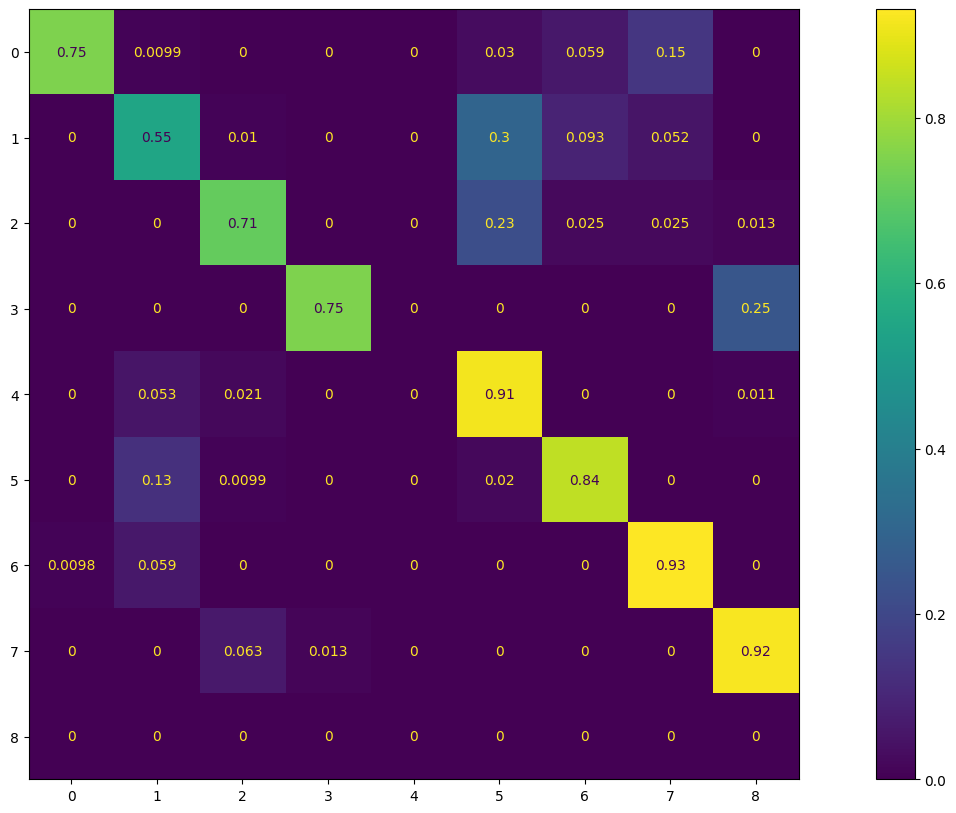

In [64]:
fig, ax = plt.subplots(figsize=(20, 10))
ConfusionMatrixDisplay.from_predictions(true_categories, predicted_categories, display_labels=class_names, xticks_rotation="vertical", normalize='true', ax=ax)
plt.show()

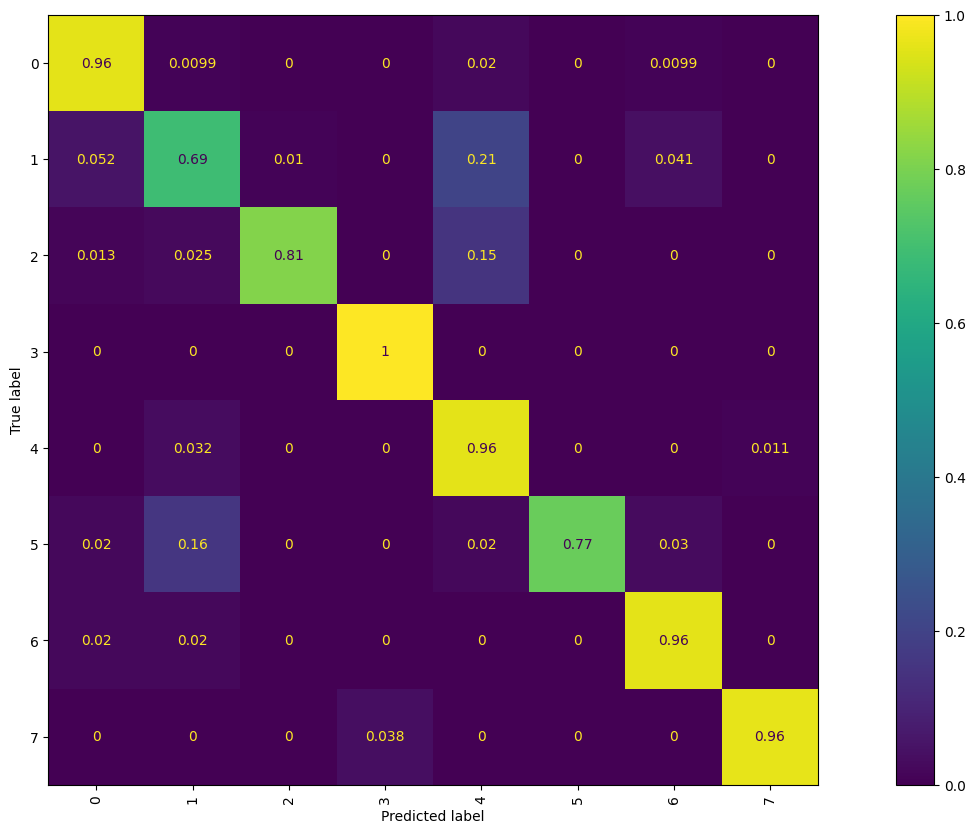

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
ConfusionMatrixDisplay.from_predictions(true_categories, predicted_categories, xticks_rotation="vertical", normalize='true', ax=ax)
plt.show()

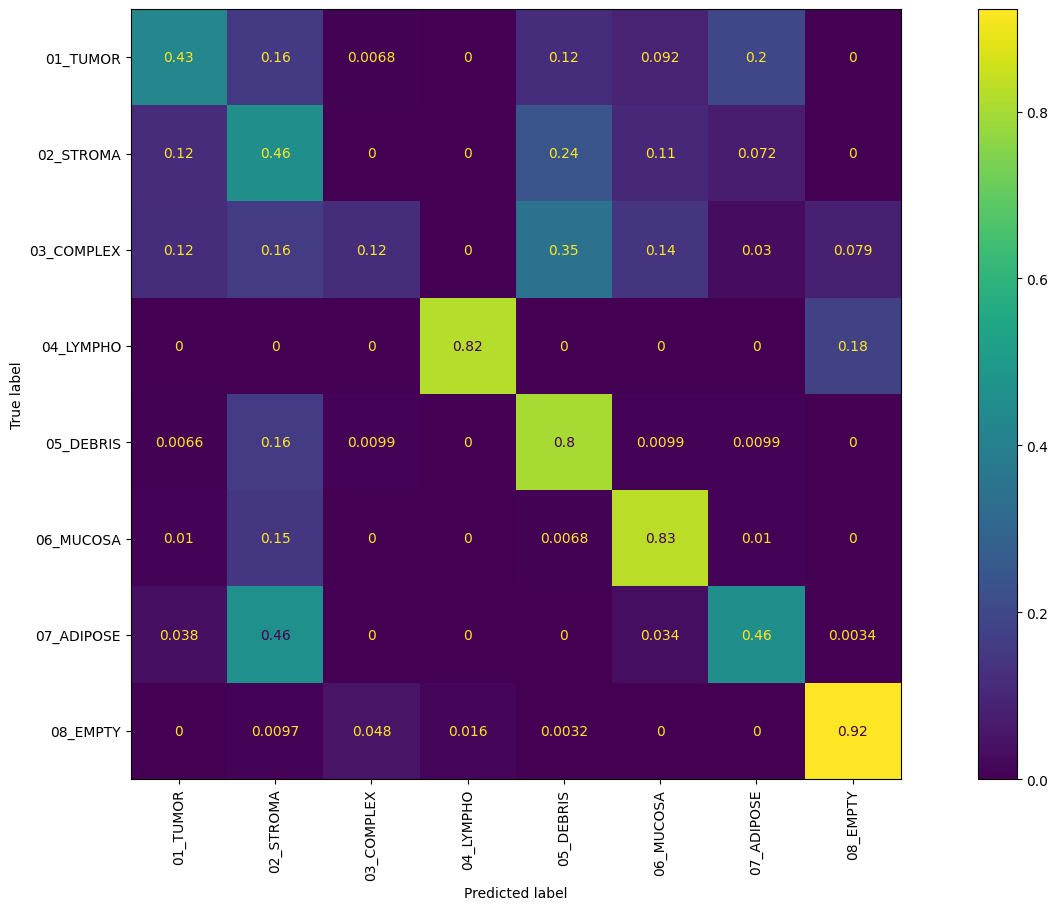

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
ConfusionMatrixDisplay.from_predictions(true_categories, predicted_categories, display_labels=class_names, xticks_rotation="vertical", normalize='true', ax=ax)
plt.show()

In [ ]:
test_ds_concat = test_ds_1.concatenate(test_ds_2)
true_categories_concat = concat([y for x, y in test_ds_concat], axis=0).numpy()
true_categories_concat.shape

(2368,)

In [ ]:
test_ds_concat = test_ds_2.concatenate(test_ds_1)

In [ ]:
y_pred_concat = combined_model.predict(test_ds_concat)

74/74 [==============================] - 80s 1s/step


In [ ]:
combined_model.evaluate(test_ds_concat)

In [ ]:
predicted_categories_concat = argmax(y_pred_concat, axis=1).numpy()
predicted_categories_concat.shape

(2368,)

ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of labels (8).

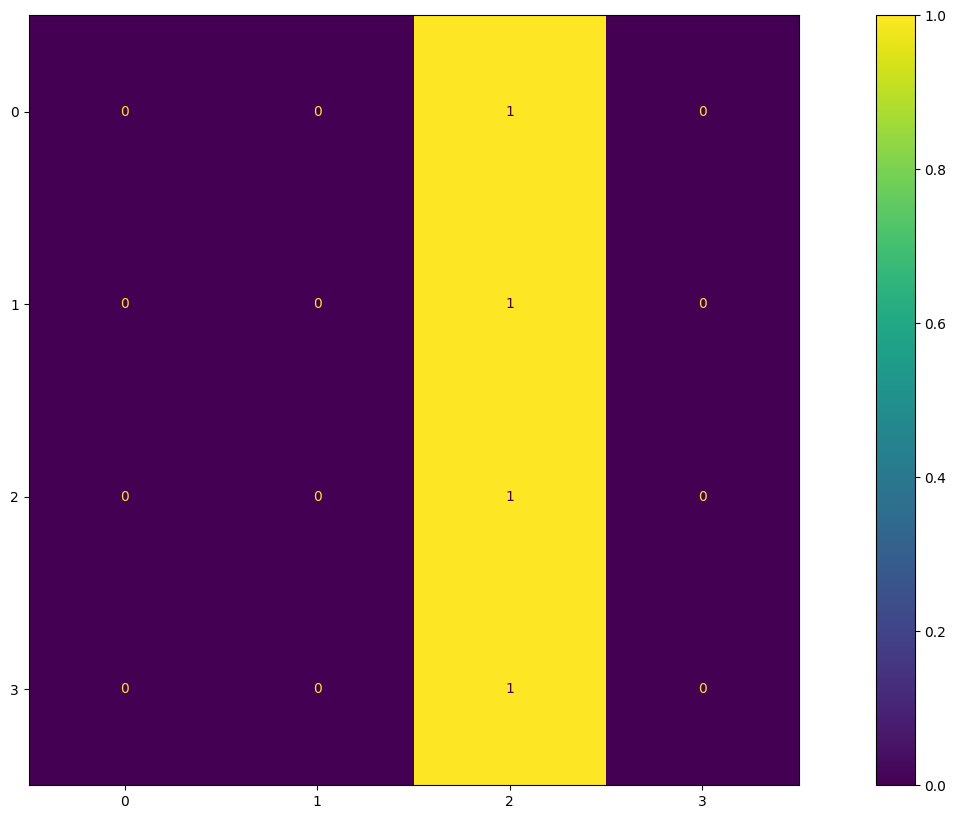

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
ConfusionMatrixDisplay.from_predictions(true_categories_concat, predicted_categories_concat, display_labels=class_names, xticks_rotation="vertical", normalize='true', ax=ax)
plt.show()

# Training Merged dataset

## VGG19

In [ ]:
model_name = "VGG19"

In [ ]:
base_model = keras.applications.VGG19(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(image_size[0], image_size[1], 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.


80134624/80134624 [==============================] - 4s 0us/step


In [ ]:
# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(image_size[0], image_size[1], 3))


# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(number_of_classes, activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

Model: "model_2"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_6 (InputLayer)        [(None, 100, 100, 3)]     0         Y          
                                                                            
 rescaling_2 (Rescaling)     (None, 100, 100, 3)       0         Y          
                                                                            
 vgg19 (Functional)          (None, 3, 3, 512)         2002438   N          
                                                       4                    
                                                                            
 global_average_pooling2d_2  (None, 512)               0         Y          
  (GlobalAveragePooling2D)                                                  
                                                                            
 dropout_2 (Dropout)         (None, 512)               0   

In [ ]:
checkpoint_filepath = f"{os.environ['DRIVE_DATA_DIR']}/training_results/intermediate-{model_name}-{os.environ['DATASET']}"+".{epoch:02d}-{val_loss:.2f}-phase-1.keras"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = False,
    save_weights_only = False,
    save_freq = "epoch")

In [ ]:
model.compile(
    optimizer=phase_1_optimizer(),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy'],
)

print("Fitting the top layer of the model")
model.fit(train_ds, epochs=epoch_counts[0], validation_data=validation_ds, callbacks=[model_checkpoint_callback])

Fitting the top layer of the model
Epoch 1/10
2427/2427 [==============================] - ETA: 0s - loss: 0.6613 - accuracy: 0.7838
Epoch 1: saving model to ./gdrive/MyDrive/master-thesis/training_results/intermediate-VGG19-merged_datasets.01-0.47-phase-1.keras
2427/2427 [==============================] - 133s 54ms/step - loss: 0.6613 - accuracy: 0.7838 - val_loss: 0.4685 - val_accuracy: 0.8439
Epoch 2/10
2427/2427 [==============================] - ETA: 0s - loss: 0.4980 - accuracy: 0.8276
Epoch 2: saving model to ./gdrive/MyDrive/master-thesis/training_results/intermediate-VGG19-merged_datasets.02-0.43-phase-1.keras
2427/2427 [==============================] - 125s 51ms/step - loss: 0.4980 - accuracy: 0.8276 - val_loss: 0.4287 - val_accuracy: 0.8581
Epoch 3/10
2427/2427 [==============================] - ETA: 0s - loss: 0.4748 - accuracy: 0.8360
Epoch 3: saving model to ./gdrive/MyDrive/master-thesis/training_results/intermediate-VGG19-merged_datasets.03-0.41-phase-1.keras
2427/2427

In [ ]:
# accuracy_phase_1 = model.history.history["accuracy"]
# val_accuracy_phase_1 = model.history.history["val_accuracy"]
# loss_phase_1 = model.history.history["loss"]
# val_loss_phase_1 = model.history.history["val_loss"]

accuracy_phase_1 = [0.7838, 0.8276, 0.8360, 0.8409, 0.8435, 0.8451, 0.8468, 0.8471, 0.8482, 0.8496]
val_accuracy_phase_1 = [0.8439, 0.8581, 0.8630, 0.8660, 0.8685, 0.8705, 0.8712, 0.8705, 0.8722, 0.8729]

loss_phase_1 = [0.6613, 0.4980, 0.4748, 0.4601, 0.4553, 0.4486, 0.4468, 0.4452, 0.4403, 0.4386]
val_loss_phase_1 = [0.4685, 0.4287, 0.4092, 0.3979, 0.3909, 0.3874, 0.3834, 0.3805, 0.3788, 0.3771]

In [ ]:
checkpoint_filepath = f"{os.environ['DRIVE_DATA_DIR']}/training_results/intermediate-{model_name}-{os.environ['DATASET']}"+".{epoch:02d}-{val_loss:.2f}-phase-2.keras"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = False,
    save_weights_only = False,
    save_freq = "epoch")

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=phase_2_optimizer(),  # Low learning rate
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy'],
)

print("Fitting the end-to-end model")
model.fit(train_ds, epochs=epoch_counts[1], validation_data=validation_ds, callbacks=[model_checkpoint_callback])

Model: "model_2"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_6 (InputLayer)        [(None, 100, 100, 3)]     0         Y          
                                                                            
 rescaling_2 (Rescaling)     (None, 100, 100, 3)       0         Y          
                                                                            
 vgg19 (Functional)          (None, 3, 3, 512)         2002438   Y          
                                                       4                    
                                                                            
 global_average_pooling2d_2  (None, 512)               0         Y          
  (GlobalAveragePooling2D)                                                  
                                                                            
 dropout_2 (Dropout)         (None, 512)               0   

In [ ]:
accuracy_phase_2_1 = [0.9228, 0.9612, 0.9730, 0.9779, 0.9818, 0.9839, 0.9844, 0.9843]
val_accuracy_phase_2_1 = [0.9472, 0.9706, 0.9737, 0.9716, 0.9769, 0.9796, 0.9764, 0.9641]

loss_phase_2_1 = [0.1530, 0.0918, 0.0865, 0.1069, 0.0875, 0.0774, 0.0928, 0.1345]
val_loss_phase_2_1 = [0.2340, 0.1186, 0.0841, 0.0673, 0.0571, 0.0557, 0.0530, 0.0548]

In [ ]:
model = keras.models.load_model(f"{os.environ['DRIVE_DATA_DIR']}/training_results/intermediate-{model_name}-{os.environ['DATASET']}.08-0.13-phase-2.keras")

In [ ]:
model.fit(train_ds, epochs=2, validation_data=validation_ds, callbacks=[model_checkpoint_callback])

Epoch 1/2
2427/2427 [==============================] - ETA: 0s - loss: 0.0575 - accuracy: 0.9844
Epoch 1: saving model to ./gdrive/MyDrive/master-thesis/training_results/intermediate-VGG19-merged_datasets.01-0.13-phase-2.keras
2427/2427 [==============================] - 347s 139ms/step - loss: 0.0575 - accuracy: 0.9844 - val_loss: 0.1308 - val_accuracy: 0.9749
Epoch 2/2
2427/2427 [==============================] - ETA: 0s - loss: 0.0647 - accuracy: 0.9834
Epoch 2: saving model to ./gdrive/MyDrive/master-thesis/training_results/intermediate-VGG19-merged_datasets.02-0.07-phase-2.keras
2427/2427 [==============================] - 346s 142ms/step - loss: 0.0647 - accuracy: 0.9834 - val_loss: 0.0740 - val_accuracy: 0.9797


### Accuracy

In [ ]:
accuracy_phase_2 = accuracy_phase_2_1 + model.history.history["accuracy"]
val_accuracy_phase_2 = val_accuracy_phase_2_1 + model.history.history["val_accuracy"]
loss_phase_2 = loss_phase_2_1 + model.history.history["loss"]
val_loss_phase_2 = val_loss_phase_2_1 + model.history.history["val_loss"]

In [ ]:
print("Test dataset evaluation")
model.evaluate(test_ds)

Test dataset evaluation
520/520 [==============================] - 21s 40ms/step - loss: 0.0806 - accuracy: 0.9795


[0.08057192713022232, 0.9795072078704834]

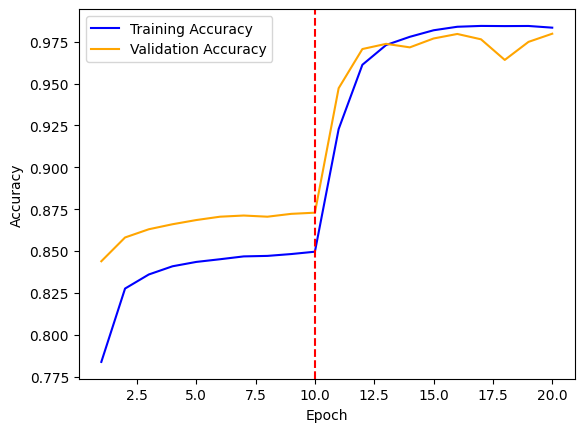

In [ ]:
# Visualize loss history
plt.plot(range(1, sum(epoch_counts) + 1), accuracy_phase_1+accuracy_phase_2, color='blue')
plt.plot(range(1, sum(epoch_counts) + 1), val_accuracy_phase_1+val_accuracy_phase_2, color='orange')
plt.axvline(x=epoch_counts[0], color='r', linestyle='--')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

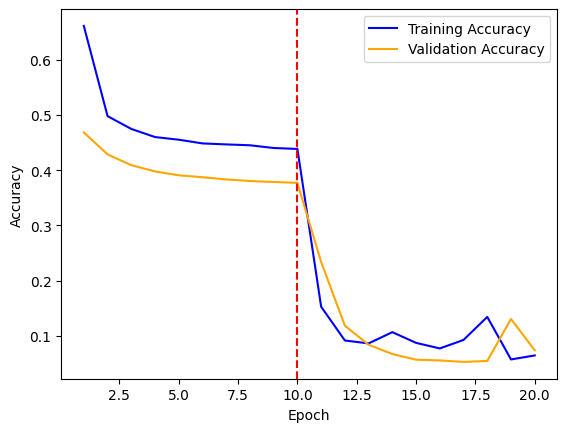

In [ ]:
# Visualize loss history
plt.plot(range(1, sum(epoch_counts) + 1), loss_phase_1+loss_phase_2, color='blue')
plt.plot(range(1, sum(epoch_counts) + 1), val_loss_phase_1+val_loss_phase_2, color='orange')
plt.axvline(x=epoch_counts[0], color='r', linestyle='--')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

## MobileNetV2

In [ ]:
model_name = "MobileNetV2"

In [ ]:
base_model = keras.applications.MobileNetV2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(image_size[0], image_size[1], 3),
    include_top=False,
    alpha=1.0
)  # Do not include the ImageNet classifier at the top.

9406464/9406464 [==============================] - 2s 0us/step


In [ ]:
# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(image_size[0], image_size[1], 3))


# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(number_of_classes, activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         Y          
                                                                            
 rescaling (Rescaling)       (None, 100, 100, 3)       0         Y          
                                                                            
 mobilenetv2_1.00_224 (Func  (None, 4, 4, 1280)        2257984   N          
 tional)                                                                    
                                                                            
 global_average_pooling2d (  (None, 1280)              0         Y          
 GlobalAveragePooling2D)                                                    
                                                                            
 dropout (Dropout)           (None, 1280)              0     

In [ ]:
checkpoint_filepath = f"{os.environ['DRIVE_DATA_DIR']}/training_results/intermediate-{model_name}-{os.environ['DATASET']}"+".{epoch:02d}-{val_loss:.2f}-phase-1.keras"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = False,
    save_weights_only = False,
    save_freq = "epoch")

In [ ]:
model.compile(
    optimizer=phase_1_optimizer(),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy'],
)

print("Fitting the top layer of the model")
model.fit(train_ds, epochs=epoch_counts[0], validation_data=validation_ds, callbacks=[model_checkpoint_callback])


Fitting the top layer of the model
Epoch 1/10
2427/2427 [==============================] - ETA: 0s - loss: 0.4481 - accuracy: 0.8553
Epoch 1: saving model to ./gdrive/MyDrive/master-thesis/training_results/intermediate-MobileNetV2-merged_datasets.01-0.35-phase-1.keras
2427/2427 [==============================] - 123s 48ms/step - loss: 0.4481 - accuracy: 0.8553 - val_loss: 0.3533 - val_accuracy: 0.8845
Epoch 2/10
2425/2427 [============================>.] - ETA: 0s - loss: 0.3640 - accuracy: 0.8839
Epoch 2: saving model to ./gdrive/MyDrive/master-thesis/training_results/intermediate-MobileNetV2-merged_datasets.02-0.30-phase-1.keras
2427/2427 [==============================] - 129s 53ms/step - loss: 0.3639 - accuracy: 0.8839 - val_loss: 0.3046 - val_accuracy: 0.9070
Epoch 3/10
2424/2427 [============================>.] - ETA: 0s - loss: 0.3587 - accuracy: 0.8869
Epoch 3: saving model to ./gdrive/MyDrive/master-thesis/training_results/intermediate-MobileNetV2-merged_datasets.03-0.33-phase

In [ ]:
accuracy_phase_1 = model.history.history["accuracy"]
val_accuracy_phase_1 = model.history.history["val_accuracy"]

In [ ]:
loss_phase_1 = model.history.history["loss"]
val_loss_phase_1 = model.history.history["val_loss"]

In [ ]:
checkpoint_filepath = f"{os.environ['DRIVE_DATA_DIR']}/training_results/intermediate-{model_name}-{os.environ['DATASET']}"+".{epoch:02d}-{val_loss:.2f}-phase-2.keras"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = False,
    save_weights_only = False,
    save_freq = "epoch")

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=phase_2_optimizer(),  # Low learning rate
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy'],
)

print("Fitting the end-to-end model")
model.fit(train_ds, epochs=epoch_counts[1], validation_data=validation_ds, callbacks=[model_checkpoint_callback])

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         Y          
                                                                            
 rescaling (Rescaling)       (None, 100, 100, 3)       0         Y          
                                                                            
 mobilenetv2_1.00_224 (Func  (None, 4, 4, 1280)        2257984   Y          
 tional)                                                                    
                                                                            
 global_average_pooling2d (  (None, 1280)              0         Y          
 GlobalAveragePooling2D)                                                    
                                                                            
 dropout (Dropout)           (None, 1280)              0     

### Accuracy

In [ ]:
accuracy_phase_2 = model.history.history["accuracy"]
val_accuracy_phase_2 = model.history.history["val_accuracy"]

loss_phase_2 = model.history.history["loss"]
val_loss_phase_2 = model.history.history["val_loss"]

In [ ]:
print("Test dataset evaluation")
model.evaluate(test_ds)

Test dataset evaluation
520/520 [==============================] - 13s 26ms/step - loss: 0.1035 - accuracy: 0.9769


[0.10351080447435379, 0.9768629670143127]

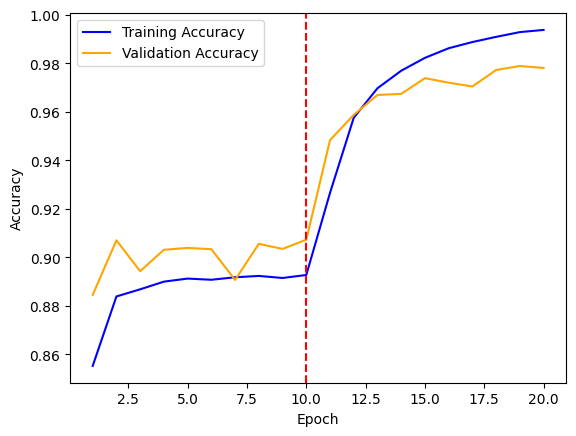

In [ ]:
# Visualize loss history
plt.plot(range(1, sum(epoch_counts) + 1), accuracy_phase_1+accuracy_phase_2, color='blue')
plt.plot(range(1, sum(epoch_counts) + 1), val_accuracy_phase_1+val_accuracy_phase_2, color='orange')
plt.axvline(x=epoch_counts[0], color='r', linestyle='--')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

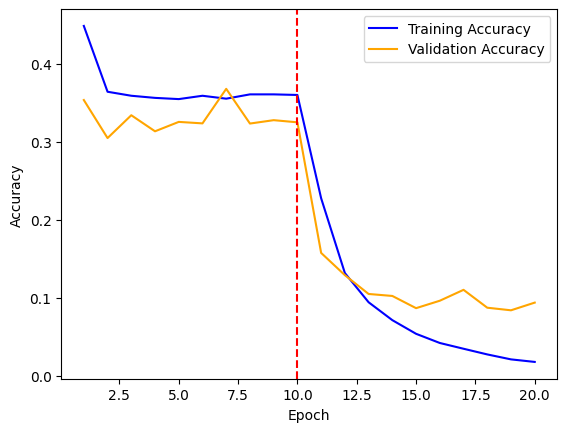

In [ ]:
# Visualize loss history
plt.plot(range(1, sum(epoch_counts) + 1), loss_phase_1+loss_phase_2, color='blue')
plt.plot(range(1, sum(epoch_counts) + 1), val_loss_phase_1+val_loss_phase_2, color='orange')
plt.axvline(x=epoch_counts[0], color='r', linestyle='--')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

## EfficientNetV2B0

In [ ]:
model_name = "EfficientNetV2B0"

In [ ]:
base_model = keras.applications.EfficientNetV2B0(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(image_size[0], image_size[1], 3),
    include_top=False,
    include_preprocessing=False,
)  # Do not include the ImageNet classifier at the top.

24274472/24274472 [==============================] - 2s 0us/step


In [ ]:
# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(image_size[0], image_size[1], 3))


# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(number_of_classes, activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

Model: "model_1"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_4 (InputLayer)        [(None, 100, 100, 3)]     0         Y          
                                                                            
 rescaling_1 (Rescaling)     (None, 100, 100, 3)       0         Y          
                                                                            
 efficientnetv2-b0 (Functio  (None, 4, 4, 1280)        5919312   N          
 nal)                                                                       
                                                                            
 global_average_pooling2d_1  (None, 1280)              0         Y          
  (GlobalAveragePooling2D)                                                  
                                                                            
 dropout_1 (Dropout)         (None, 1280)              0   

In [ ]:
checkpoint_filepath = f"{os.environ['DRIVE_DATA_DIR']}/training_results/intermediate-{model_name}-{os.environ['DATASET']}"+".{epoch:02d}-{val_loss:.2f}-phase-1.keras"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = False,
    save_weights_only = False,
    save_freq = "epoch")

In [ ]:
model.compile(
    optimizer=phase_1_optimizer(),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy'],
)

print("Fitting the top layer of the model")
model.fit(train_ds, epochs=epoch_counts[0], validation_data=validation_ds, callbacks=[model_checkpoint_callback])


Fitting the top layer of the model
Epoch 1/10
2427/2427 [==============================] - ETA: 0s - loss: 0.4173 - accuracy: 0.8652
Epoch 1: saving model to ./gdrive/MyDrive/master-thesis/training_results/intermediate-EfficientNetV2B0-merged_datasets.01-0.30-phase-1.keras
2427/2427 [==============================] - 109s 42ms/step - loss: 0.4173 - accuracy: 0.8652 - val_loss: 0.3025 - val_accuracy: 0.8985
Epoch 2/10
2427/2427 [==============================] - ETA: 0s - loss: 0.3067 - accuracy: 0.8972
Epoch 2: saving model to ./gdrive/MyDrive/master-thesis/training_results/intermediate-EfficientNetV2B0-merged_datasets.02-0.27-phase-1.keras
2427/2427 [==============================] - 90s 37ms/step - loss: 0.3067 - accuracy: 0.8972 - val_loss: 0.2675 - val_accuracy: 0.9115
Epoch 3/10
2426/2427 [============================>.] - ETA: 0s - loss: 0.2875 - accuracy: 0.9039
Epoch 3: saving model to ./gdrive/MyDrive/master-thesis/training_results/intermediate-EfficientNetV2B0-merged_datasets

In [ ]:
accuracy_phase_1 = model.history.history["accuracy"]
val_accuracy_phase_1 = model.history.history["val_accuracy"]

In [ ]:
loss_phase_1 = model.history.history["loss"]
val_loss_phase_1 = model.history.history["val_loss"]

In [ ]:
checkpoint_filepath = f"{os.environ['DRIVE_DATA_DIR']}/training_results/intermediate-{model_name}-{os.environ['DATASET']}"+".{epoch:02d}-{val_loss:.2f}-phase-2.keras"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = False,
    save_weights_only = False,
    save_freq = "epoch")

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=phase_2_optimizer(),  # Low learning rate
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy'],
)

print("Fitting the end-to-end model")
model.fit(train_ds, epochs=epoch_counts[1], validation_data=validation_ds, callbacks=[model_checkpoint_callback])

Model: "model_1"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_4 (InputLayer)        [(None, 100, 100, 3)]     0         Y          
                                                                            
 rescaling_1 (Rescaling)     (None, 100, 100, 3)       0         Y          
                                                                            
 efficientnetv2-b0 (Functio  (None, 4, 4, 1280)        5919312   Y          
 nal)                                                                       
                                                                            
 global_average_pooling2d_1  (None, 1280)              0         Y          
  (GlobalAveragePooling2D)                                                  
                                                                            
 dropout_1 (Dropout)         (None, 1280)              0   

### Accuracy

In [ ]:
accuracy_phase_2 = model.history.history["accuracy"]
val_accuracy_phase_2 = model.history.history["val_accuracy"]

In [ ]:
loss_phase_2 = model.history.history["loss"]
val_loss_phase_2 = model.history.history["val_loss"]

In [ ]:
print("Test dataset evaluation")
model.evaluate(test_ds)

Test dataset evaluation
520/520 [==============================] - 14s 26ms/step - loss: 0.0994 - accuracy: 0.9770


[0.09941484034061432, 0.9770432710647583]

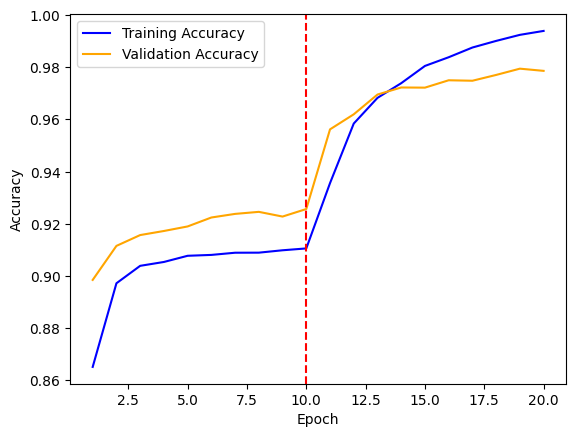

In [ ]:
# Visualize loss history
plt.plot(range(1, sum(epoch_counts) + 1), accuracy_phase_1+accuracy_phase_2, color='blue')
plt.plot(range(1, sum(epoch_counts) + 1), val_accuracy_phase_1+val_accuracy_phase_2, color='orange')
plt.axvline(x=epoch_counts[0], color='r', linestyle='--')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

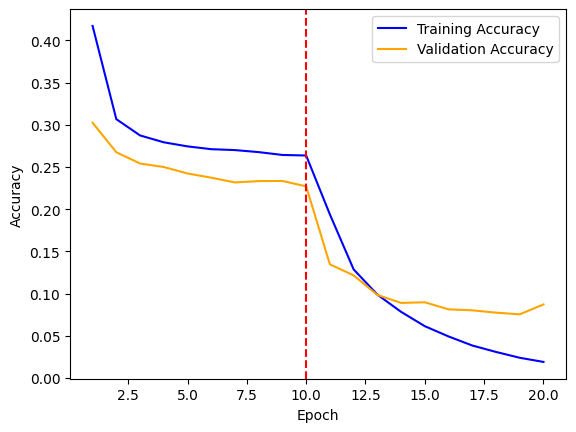

In [ ]:
# Visualize loss history
plt.plot(range(1, sum(epoch_counts) + 1), loss_phase_1+loss_phase_2, color='blue')
plt.plot(range(1, sum(epoch_counts) + 1), val_loss_phase_1+val_loss_phase_2, color='orange')
plt.axvline(x=epoch_counts[0], color='r', linestyle='--')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

# Saving

In [ ]:
print(f"""
Model name: {model_name}
Dataset: {os.environ['DATASET']}
Image format: {os.environ['IMAGE_FORMAT']}
Image dimensions: {image_size[0]}x{image_size[1]}
Batch size: {batch_size}
Phase 1 optimizer: {phase1optimizer}
Phase 2 optimizer: {phase2optimizer}
      """)


Model name: VGG19
Dataset: merged_datasets
Image format: png
Image dimensions: 100x100
Batch size: 32
Phase 1 optimizer: RMSprop
Phase 2 optimizer: RMSprop
      


In [ ]:
metrics = [
    {"accuracy": accuracy_phase_1, "val_accuracy": val_accuracy_phase_1, "loss": loss_phase_1, "val_loss": val_loss_phase_1},
     {"accuracy": accuracy_phase_2, "val_accuracy": val_accuracy_phase_2, "loss": loss_phase_2, "val_loss": val_loss_phase_2}
    ]

train_info = metrics, seed

In [ ]:
# Open a file and use dump()
with open(f"{os.environ['DRIVE_DATA_DIR']}/training_results/{model_name}-{os.environ['DATASET']}-{os.environ['IMAGE_FORMAT']}-{image_size[0]}x{image_size[1]}-{batch_size}-{phase1optimizer}+{phase2optimizer}-70:15:15.pkl", 'wb') as file:

	# A new file will be created
	pickle.dump(train_info, file)


In [ ]:
model.save(f"{os.environ['DRIVE_DATA_DIR']}/training_results/{model_name}-{os.environ['DATASET']}-{os.environ['IMAGE_FORMAT']}-{image_size[0]}x{image_size[1]}-{batch_size}-{phase1optimizer}+{phase2optimizer}-70:15:15.keras")